<a href="https://colab.research.google.com/github/darrencheninfo/ADS504_G1_Project/blob/main/ADS504_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

This is the exploration of the Dept of Transportation Flight analytics data from 2009-2019 - looking at the various factors that may contribute to airline delays and predict how long these airlines will likely delay. 

## Setup

### Get Libraries

In [1]:
# %pip install --upgrade numpy scipy
# %pip install --upgrade cupy
# %pip install missingno

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

### Import Dataset

In [3]:
#import dataset
# df = pd.read_sas('/content/drive/MyDrive/ADS 504 | Final Project/LLCP2023.XPT ', format='xport') # replace with your dataset path
df = pd.read_csv("Data RAW/2018.csv")

In [4]:
df.shape

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7213446 entries, 0 to 7213445
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   OP_CARRIER_FL_NUM    int64  
 3   ORIGIN               object 
 4   DEST                 object 
 5   CRS_DEP_TIME         int64  
 6   DEP_TIME             float64
 7   DEP_DELAY            float64
 8   TAXI_OUT             float64
 9   WHEELS_OFF           float64
 10  WHEELS_ON            float64
 11  TAXI_IN              float64
 12  CRS_ARR_TIME         int64  
 13  ARR_TIME             float64
 14  ARR_DELAY            float64
 15  CANCELLED            float64
 16  CANCELLATION_CODE    object 
 17  DIVERTED             float64
 18  CRS_ELAPSED_TIME     float64
 19  ACTUAL_ELAPSED_TIME  float64
 20  AIR_TIME             float64
 21  DISTANCE             float64
 22  CARRIER_DELAY        float64
 23  WEATHER_DELAY        float64
 24

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,...,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,UA,2427,LAS,SFO,1115,1107.0,-8.0,11.0,1118.0,...,99.0,83.0,65.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,UA,2426,SNA,DEN,1335,1330.0,-5.0,15.0,1345.0,...,134.0,126.0,106.0,846.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,UA,2425,RSW,ORD,1546,1552.0,6.0,19.0,1611.0,...,190.0,182.0,157.0,1120.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,UA,2424,ORD,ALB,630,650.0,20.0,13.0,703.0,...,112.0,106.0,83.0,723.0,NaN,NaN,NaN,NaN,NaN,NaN


## Pre-Processing

### Code Explanation
This section prints the dataframe shape and drops the unnecessary "unnamed" column.

In [5]:
# 1) Basic Shape, columns, dtypes

print(f"Rows: {len(df):,} | Cols: {df.shape[1]}")
print("\nColumn dtypes:")
print(df.dtypes)

# Drop obvious artifacts (e.g., unnamed columns)
artifact_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
if artifact_cols:
    df = df.drop(columns=artifact_cols)
    print(f"\nDropped artifact columns: {artifact_cols}")

Rows: 7,213,446 | Cols: 28

Column dtypes:
FL_DATE                 object
OP_CARRIER              object
OP_CARRIER_FL_NUM        int64
ORIGIN                  object
DEST                    object
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE       object
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 27            float64
dtype: object

Dropped artifact columns: ['Unnamed: 27']


### Code Explanation
Format the column names to standardize nomenclature.

In [6]:
# 2) Standardize column names (optional tidy)

df.columns = (
    df.columns
      .str.strip()
      .str.replace(r"\s+", "_", regex=True)
      .str.replace("[^0-9a-zA-Z_]", "", regex=True)
      .str.upper()
)

### Code Explanation
Split all the column names of the data frame into lists of similar data types. This will help with converting data later on.

In [7]:
# 3) Known schema helpers & safe numeric conversions

# Columns present in your sample (adjust if your file differs)

time_like_cols = [
    "CRS_DEP_TIME", "DEP_TIME", "WHEELS_OFF", "WHEELS_ON",
    "CRS_ARR_TIME", "ARR_TIME"
]

delay_cols = [
    "DEP_DELAY", "ARR_DELAY", "CARRIER_DELAY", "WEATHER_DELAY",
    "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"
]

duration_cols = ["TAXI_OUT", "TAXI_IN", "CRS_ELAPSED_TIME", "ACTUAL_ELAPSED_TIME", "AIR_TIME"]

binary_indicator_cols = ["CANCELLED", "DIVERTED"]

id_like_cols = ["OP_CARRIER_FL_NUM", "DISTANCE"]

### Code Explanation
All numeric columns are expected to have numeric values. Any non-numeric values, such as "N/A" or "None" or "???," will be changed to NaN using errors="coerce".

In [8]:
# Coerce numerics safely (keeps NaN for non-convertible)
to_numeric_cols = list(set(time_like_cols + delay_cols + duration_cols + binary_indicator_cols + id_like_cols) & set(df.columns))
for c in to_numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

### Code Explanation
The code converts HHMM date times into a single integer with minute units. It then creates columns for localized times of scheduled departure, actual departure, scheduled arrival, and actual arrival with proper adjustments for flights that cross midnight.

In [9]:
# 4) Parse dates & clock HHMM ints

def hhmm_to_minutes(x):
    """Convert HHMM (e.g., 705, 1305) to minutes since midnight."""
    if pd.isna(x):
        return np.nan
    x = int(x)
    hh, mm = divmod(x, 100)
    if (hh < 0) or (hh > 23) or (mm < 0) or (mm > 59):
        return np.nan
    return hh * 60 + mm

def combine_date_time(date_series, hhmm_series):
    """Combine FL_DATE (YYYY-MM-DD) with HHMM into pandas datetime (naive, local)."""
    mins = hhmm_series.apply(hhmm_to_minutes)
    # midnight anchor; add minutes
    dt = pd.to_datetime(date_series, errors="coerce") + pd.to_timedelta(mins, unit="m")
    return dt

# Parse FL_DATE
if "FL_DATE" in df.columns:
    df["FL_DATE"] = pd.to_datetime(df["FL_DATE"], errors="coerce")

# Create datetime stamps (naive local time)
if set(["FL_DATE", "CRS_DEP_TIME"]).issubset(df.columns):
    df["CRS_DEP_DT"] = combine_date_time(df["FL_DATE"], df["CRS_DEP_TIME"])
if set(["FL_DATE", "DEP_TIME"]).issubset(df.columns):
    df["DEP_DT"] = combine_date_time(df["FL_DATE"], df["DEP_TIME"])
if set(["FL_DATE", "CRS_ARR_TIME"]).issubset(df.columns):
    # NOTE: arrival may be next day; adjust if actual < scheduled or elapsed > 24h as needed
    df["CRS_ARR_DT"] = combine_date_time(df["FL_DATE"], df["CRS_ARR_TIME"])
if set(["FL_DATE", "ARR_TIME"]).issubset(df.columns):
    df["ARR_DT"] = combine_date_time(df["FL_DATE"], df["ARR_TIME"])

# Simple next-day correction for arrivals crossing midnight (optional)
if {"CRS_DEP_DT", "CRS_ARR_DT"}.issubset(df.columns):
    mask_next = (df["CRS_ARR_DT"] < df["CRS_DEP_DT"])
    df.loc[mask_next, "CRS_ARR_DT"] = df.loc[mask_next, "CRS_ARR_DT"] + pd.Timedelta(days=1)
if {"DEP_DT", "ARR_DT"}.issubset(df.columns):
    mask_next = (df["ARR_DT"] < df["DEP_DT"])
    df.loc[mask_next, "ARR_DT"] = df.loc[mask_next, "ARR_DT"] + pd.Timedelta(days=1)

### Code Explanation
This section focuses on encoding categorical variables. In the "CANCELLED" and "DIVERTED" columns, if the value is NA, then it will be replaced as 0 for on-time. "CANCELLATION_CODE" was encoded to letters. Finally, a new column "IS_DELAYED_15" was created to be a practical business target. If the actual arrival time was equal or greater than 15 minutes, then it is marked as delayed.

In [10]:
# 5) Cancellation codes & binary targets

# Normalize CANCELLED/DIVERTED to 0/1 ints
for c in ["CANCELLED", "DIVERTED"]:
    if c in df.columns:
        df[c] = (df[c].fillna(0) > 0).astype("int8")

# Map cancellation reason codes
if "CANCELLATION_CODE" in df.columns:
    code_map = {"A": "Carrier", "B": "Weather", "C": "NAS", "D": "Security"}
    df["CANCELLATION_REASON"] = df["CANCELLATION_CODE"].map(code_map)

# A practical business target: arrival delay ≥ 15 minutes
if "ARR_DELAY" in df.columns:
    df["IS_DELAYED_15"] = (df["ARR_DELAY"].fillna(0) >= 15).astype("int8")

### Code Explanation
Preliminary EDA was conducted to examine the data's missingness, general numeric statistics, most common airlines that delay flights, most common airports that have had a delay/cancellation (both origin and destination), and most common reasons for cancellations.

In [11]:
# 6) Quick missingness & sanity EDA

def missingness_table(frame: pd.DataFrame, min_pct=0.0):
    miss = frame.isna().mean().sort_values(ascending=False).to_frame("missing_pct")
    miss["n_missing"] = (frame.shape[0] * miss["missing_pct"]).round().astype(int)
    out = miss[miss["missing_pct"] >= min_pct]
    return (out * 100).round(2).rename(columns={"missing_pct": "missing_%"}).sort_values("missing_%", ascending=False)

print("\nMissingness (%):")
display(missingness_table(df, min_pct=0.0).head(20))

# Numeric summary
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric describe (selected):")
display(df[num_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T.round(2).head(25))

# Categorical peek
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in cat_cols:
    print(f"\nTop values for {c}:")
    display(df[c].value_counts(dropna=False).head(10))


Missingness (%):


,missing_%,n_missing
CANCELLATION_CODE,98.38,709686200
CANCELLATION_REASON,98.38,709686200
CARRIER_DELAY,81.25,586073600
NAS_DELAY,81.25,586073600
SECURITY_DELAY,81.25,586073600
LATE_AIRCRAFT_DELAY,81.25,586073600
WEATHER_DELAY,81.25,586073600
ARR_DELAY,1.90,13704000
ACTUAL_ELAPSED_TIME,1.86,13444200
AIR_TIME,1.86,13444200



Numeric describe (selected):


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
OP_CARRIER_FL_NUM,7213446.0,2607.53,1860.12,1.0,40.0,233.0,1029.0,2131.0,4074.0,5883.0,6444.0,7909.0
CRS_DEP_TIME,7213446.0,1329.69,490.93,1.0,520.0,604.0,915.0,1320.0,1735.0,2129.0,2245.0,2359.0
DEP_TIME,7101129.0,1333.85,504.51,1.0,504.0,600.0,916.0,1326.0,1744.0,2141.0,2302.0,2400.0
DEP_DELAY,7096212.0,9.97,44.83,-122.0,-14.0,-10.0,-5.0,-2.0,7.0,73.0,186.0,2710.0
TAXI_OUT,7097616.0,17.41,9.92,1.0,6.0,8.0,11.0,15.0,20.0,35.0,55.0,196.0
WHEELS_OFF,7097617.0,1357.80,505.97,1.0,505.0,616.0,932.0,1340.0,1759.0,2154.0,2311.0,2400.0
WHEELS_ON,7094200.0,1462.16,533.47,1.0,27.0,644.0,1044.0,1502.0,1911.0,2249.0,2343.0,2400.0
TAXI_IN,7094200.0,7.60,6.06,1.0,2.0,3.0,4.0,6.0,9.0,18.0,32.0,259.0
CRS_ARR_TIME,7213446.0,1486.34,518.31,1.0,31.0,714.0,1100.0,1515.0,1919.0,2255.0,2349.0,2400.0
ARR_TIME,7094201.0,1466.78,537.71,1.0,23.0,642.0,1049.0,1506.0,1916.0,2252.0,2344.0,2400.0



Top values for OP_CARRIER:


OP_CARRIER
WN    1352552
DL     949283
AA     916818
OO     774137
UA     621565
YX     316090
B6     305010
MQ     296001
OH     278457
9E     245917
Name: count, dtype: int64


Top values for ORIGIN:


ORIGIN
ATL    390046
ORD    332953
DFW    279298
DEN    235989
CLT    233317
LAX    221486
SFO    175849
PHX    173962
IAH    173806
LGA    171093
Name: count, dtype: int64


Top values for DEST:


DEST
ATL    390079
ORD    332942
DFW    279272
DEN    236020
CLT    233309
LAX    221516
SFO    175939
PHX    173953
IAH    173782
LGA    171082
Name: count, dtype: int64


Top values for CANCELLATION_CODE:


CANCELLATION_CODE
NaN    7096862
B        61984
A        29484
C        25072
D           44
Name: count, dtype: int64


Top values for CANCELLATION_REASON:


CANCELLATION_REASON
NaN         7096862
Weather       61984
Carrier       29484
NAS           25072
Security         44
Name: count, dtype: int64

### Code Explanation
A quick check on arrivals and delays. Optional code to exploring the time relationship of whether a delay cause roughly sum to ARR_DELAY when delayed.

In [12]:
# 7) Relationship checks (sanity, not strict asserts)

# Delays can be negative (early). This is just informative.
if {"DEP_DELAY", "ARR_DELAY"}.issubset(df.columns):
    print("\nDelay sanity snapshot:")
    print(df[["DEP_DELAY", "ARR_DELAY"]].describe().round(2))

# Optional: do delay causes roughly sum to ARR_DELAY (when delayed)?
# if {"ARR_DELAY", "CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"}.issubset(df.columns):
#     causes = ["CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]
#     tmp = df[["ARR_DELAY"] + causes].copy()
#     tmp["CAUSE_SUM"] = tmp[causes].fillna(0).sum(axis=1)
#     # Only look at delayed flights
#     mask = tmp["ARR_DELAY"] >= 15
#     if mask.any():
#         ratio = (tmp.loc[mask, "CAUSE_SUM"].sum() / tmp.loc[mask, "ARR_DELAY"].sum())
#         print(f"\nCause minutes / total ARR_DELAY minutes (≥15 min delays): {ratio:.2f}")





Delay sanity snapshot:
        DEP_DELAY   ARR_DELAY
count  7096212.00  7076406.00
mean         9.97        5.05
std         44.83       46.93
min       -122.00     -120.00
25%         -5.00      -14.00
50%         -2.00       -6.00
75%          7.00        8.00
max       2710.00     2692.00


### Code Explanation
This creates a key performance indicator (KPI) for the amount of delays and cancels for a particular group.

In [13]:
# 8) Grouped KPIs (business-friendly slices)

def rate_table(frame, group_col, target_col="IS_DELAYED_15", top_n=15, min_count=100):
    g = (
        frame.groupby(group_col, dropna=False)
             .agg(n=("FL_DATE","count") if "FL_DATE" in frame.columns else ("ARR_DELAY","size"),
                  delayed=(target_col, "mean") if target_col in frame.columns else ("ARR_DELAY", lambda s: (s >= 15).mean()),
                  cancel=("CANCELLED", "mean") if "CANCELLED" in frame.columns else ("ARR_DELAY", lambda s: np.nan))
             .reset_index()
    )
    g = g[g["n"] >= min_count].sort_values("delayed", ascending=False)
    g["delayed"] = (100*g["delayed"]).round(1)
    if "cancel" in g:
        g["cancel"] = (100*g["cancel"]).round(1)
    return g.head(top_n)

### Code Explanation
This is an example of the function created above. It takes the OP_CARRIER and finds the delay/cancellation rates of OP_CARRIER as well as the origin and destination.


Delay/Cancel rates by OP_CARRIER (min 100 rows):


,OP_CARRIER,n,delayed,cancel
6,F9,120035,28.5,1.9
3,B6,305010,26.7,2.1
7,G4,96221,22.1,0.8
5,EV,202890,20.4,2.8
11,OH,278457,20.2,4.3
16,YV,215138,19.8,2.6
1,AA,916818,19.7,1.6
14,VX,17670,19.5,2.5
9,MQ,296001,19.3,3.6
13,UA,621565,19.2,0.8



Delay/Cancel rates by ORIGIN (min 100 rows):


,ORIGIN,n,delayed,cancel
303,SCK,747,38.4,0.8
226,MMH,149,34.2,9.4
147,HGR,138,33.3,0.0
250,OTH,371,33.2,3.8
269,PPG,122,32.8,0.0
339,TTN,2603,31.7,3.4
252,OWB,111,30.6,3.6
249,ORH,964,30.4,4.1
240,OGD,126,30.2,0.8
332,SWF,1791,28.2,2.3



Delay/Cancel rates by DEST (min 100 rows):


,DEST,n,delayed,cancel
250,OTH,371,33.4,2.2
272,PSE,792,31.1,1.3
47,BQN,1965,30.4,0.8
113,EWR,143863,29.8,3.3
306,SFB,9600,29.7,0.7
74,CMX,728,29.3,5.4
252,OWB,110,29.1,2.7
249,ORH,974,29.0,3.6
303,SCK,747,28.9,0.8
258,PGV,896,28.9,7.1


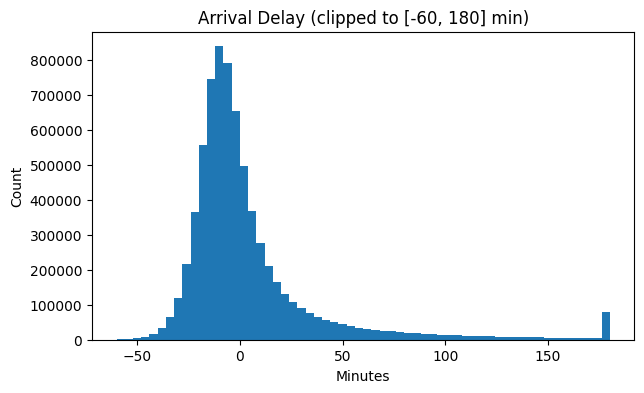

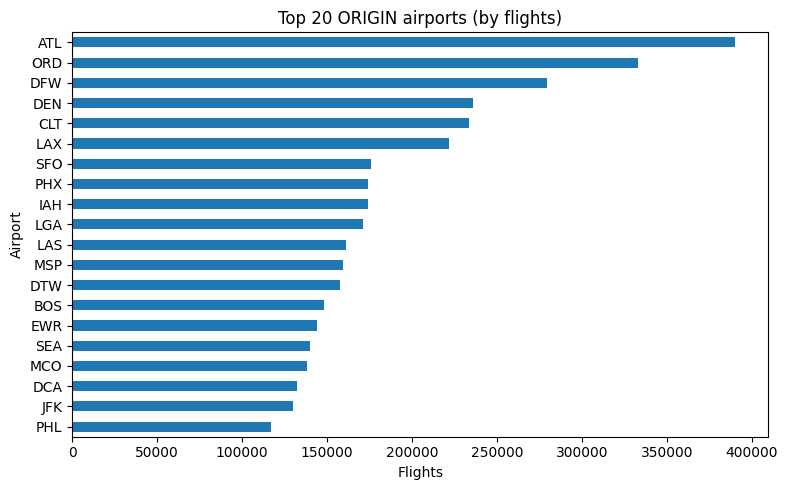

In [14]:
# Examples: carrier, origin, dest
if "OP_CARRIER" in df.columns:
    print("\nDelay/Cancel rates by OP_CARRIER (min 100 rows):")
    display(rate_table(df, "OP_CARRIER"))
if "ORIGIN" in df.columns:
    print("\nDelay/Cancel rates by ORIGIN (min 100 rows):")
    display(rate_table(df, "ORIGIN"))
if "DEST" in df.columns:
    print("\nDelay/Cancel rates by DEST (min 100 rows):")
    display(rate_table(df, "DEST"))


# 9) Simple visuals (matplotlib only)

plt.figure(figsize=(7,4))
if "ARR_DELAY" in df.columns:
    # Clip extreme positives for a readable histogram
    arr_clip = df["ARR_DELAY"].clip(lower=-60, upper=180)
    plt.hist(arr_clip.dropna(), bins=60)
    plt.title("Arrival Delay (clipped to [-60, 180] min)")
    plt.xlabel("Minutes")
    plt.ylabel("Count")
    plt.show()

# Top 20 busiest ORIGINs by count
if "ORIGIN" in df.columns:
    top_origin = df["ORIGIN"].value_counts().head(20)
    plt.figure(figsize=(8,5))
    top_origin.sort_values().plot(kind="barh")
    plt.title("Top 20 ORIGIN airports (by flights)")
    plt.xlabel("Flights")
    plt.ylabel("Airport")
    plt.tight_layout()
    plt.show()

In [15]:
# 10) Save a cleaned/typed output df

# Optional: small, typed, analysis-ready subset
keep_cols = [
    "FL_DATE","OP_CARRIER","OP_CARRIER_FL_NUM","ORIGIN","DEST",
    "CRS_DEP_TIME","DEP_TIME","DEP_DELAY","TAXI_OUT","WHEELS_OFF",
    "WHEELS_ON","TAXI_IN","CRS_ARR_TIME","ARR_TIME","ARR_DELAY",
    "CANCELLED","CANCELLATION_CODE","CANCELLATION_REASON","DIVERTED",
    "CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME","DISTANCE",
    "CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY",
    "CRS_DEP_DT","DEP_DT","CRS_ARR_DT","ARR_DT","IS_DELAYED_15"
]
keep_cols = [c for c in keep_cols if c in df.columns]
df_clean = df[keep_cols].copy()

# Example export (commented out):
# df_clean.to_parquet("dot_delays_clean.parquet", index=False)
# df_clean.to_csv("dot_delays_clean.csv", index=False)

print("\nPrepared `df_clean` with typed fields and engineered features.")
print(df_clean.head(3))


Prepared `df_clean` with typed fields and engineered features.
     FL_DATE OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  CRS_DEP_TIME  \
0 2018-01-01         UA               2429    EWR  DEN          1517   
1 2018-01-01         UA               2427    LAS  SFO          1115   
2 2018-01-01         UA               2426    SNA  DEN          1335   

   DEP_TIME  DEP_DELAY  TAXI_OUT  WHEELS_OFF  ...  CARRIER_DELAY  \
0    1512.0       -5.0      15.0      1527.0  ...            NaN   
1    1107.0       -8.0      11.0      1118.0  ...            NaN   
2    1330.0       -5.0      15.0      1345.0  ...            NaN   

   WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  LATE_AIRCRAFT_DELAY  \
0            NaN        NaN             NaN                  NaN   
1            NaN        NaN             NaN                  NaN   
2            NaN        NaN             NaN                  NaN   

           CRS_DEP_DT              DEP_DT          CRS_ARR_DT  \
0 2018-01-01 15:17:00 2018-01-01 15:

In [16]:
# Handle missing values
# These values are missing because they suggest a specific meaning. The NA values will be filled with 0 to stand for False
for col in ['CANCELLED', 'DIVERTED']:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype('int8')

# The categories only have values when a flight was cancelled. NA values will be filled with None
if 'CANCELLATION_CODE' in df.columns:
    df['CANCELLATION_CODE'] = df['CANCELLATION_CODE'].fillna('None')
if 'CANCELLATION_REASON' in df.columns:
    df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('None')

# These values typically exist, but an error may have occurred. Fill NA with median
for col in ['CRS_ELAPSED_TIME']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())
        
# These values are missing because the flight didn't happen/diverted. Fill NA with 0
actual_cols = ['DEP_TIME','ARR_TIME','ACTUAL_ELAPSED_TIME','TAXI_OUT','TAXI_IN','WHEELS_OFF','WHEELS_ON','AIR_TIME']
for col in actual_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        
# These values are NA because they mean no depature/cancelled. Fill NA with 0
delay_cols = ['DEP_DELAY','ARR_DELAY','CARRIER_DELAY','WEATHER_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY', 'NAS DELAY']
for col in delay_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        
# These values are missing actual/scheduled times. Fill NA with scheduled datetime if available, if not, 1970-01-01
datetime_cols = ['CRS_DEP_DT','DEP_DT','CRS_ARR_DT','ARR_DT']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].fillna(pd.Timestamp('1970-01-01'))

In [17]:
df2018 = df.copy()

df2018['year'] = df2018['FL_DATE'].dt.year
df2018['month'] = df2018['FL_DATE'].dt.month
df2018 = df2018.rename(columns={'OP_UNIQUE_CARRIER': 'OP_CARRIER'})

df2018.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CRS_DEP_DT,DEP_DT,CRS_ARR_DT,ARR_DT,CANCELLATION_REASON,IS_DELAYED_15,year,month
0,2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,...,0.0,0.0,2018-01-01 15:17:00,2018-01-01 15:12:00,2018-01-01 17:45:00,2018-01-01 17:22:00,None,0,2018,1
1,2018-01-01,UA,2427,LAS,SFO,1115,1107.0,-8.0,11.0,1118.0,...,0.0,0.0,2018-01-01 11:15:00,2018-01-01 11:07:00,2018-01-01 12:54:00,2018-01-01 12:30:00,None,0,2018,1
2,2018-01-01,UA,2426,SNA,DEN,1335,1330.0,-5.0,15.0,1345.0,...,0.0,0.0,2018-01-01 13:35:00,2018-01-01 13:30:00,2018-01-01 16:49:00,2018-01-01 16:36:00,None,0,2018,1
3,2018-01-01,UA,2425,RSW,ORD,1546,1552.0,6.0,19.0,1611.0,...,0.0,0.0,2018-01-01 15:46:00,2018-01-01 15:52:00,2018-01-01 17:56:00,2018-01-01 17:54:00,None,0,2018,1
4,2018-01-01,UA,2424,ORD,ALB,630,650.0,20.0,13.0,703.0,...,0.0,0.0,2018-01-01 06:30:00,2018-01-01 06:50:00,2018-01-01 09:22:00,2018-01-01 09:36:00,None,0,2018,1


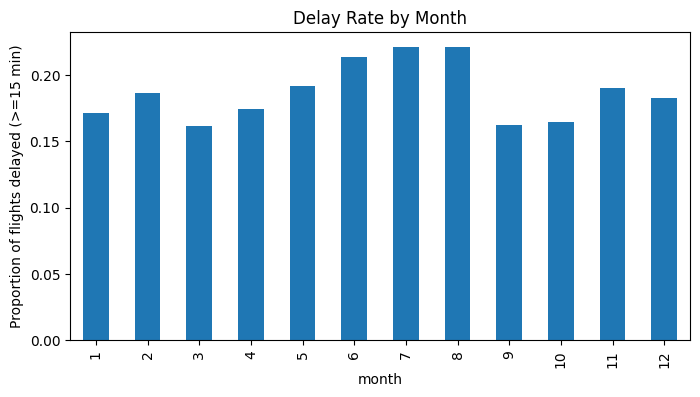

In [18]:
monthly = df2018.groupby('month')['IS_DELAYED_15'].mean()

plt.figure(figsize=(8,4))
monthly.plot(kind='bar')
plt.ylabel("Proportion of flights delayed (>=15 min)")
plt.title("Delay Rate by Month")
plt.show()

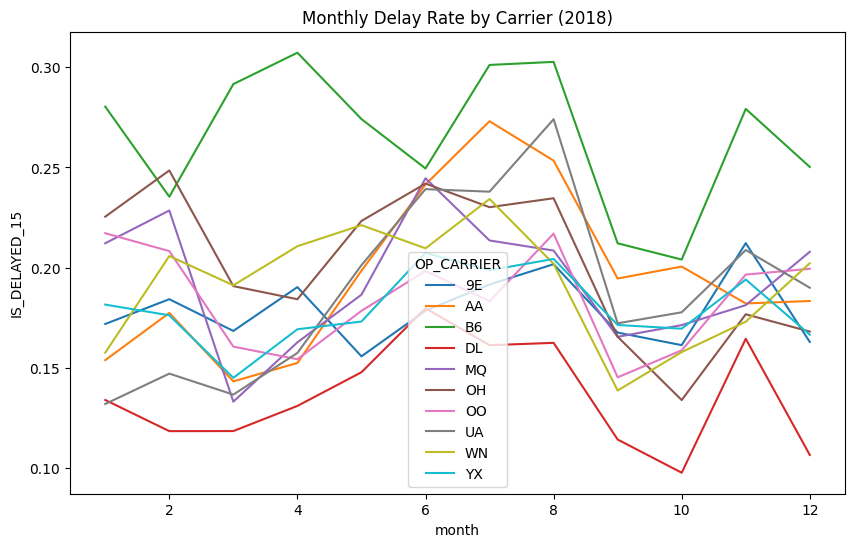

In [19]:
top10 = df2018['OP_CARRIER'].value_counts().nlargest(10).index
subset = df2018[df2018['OP_CARRIER'].isin(top10)]

carrier_monthly = (
    subset.groupby(['OP_CARRIER', 'month'])['IS_DELAYED_15'].mean().reset_index()
)

plt.figure(figsize=(10,6))
sns.lineplot(data=carrier_monthly, x='month', y='IS_DELAYED_15', hue='OP_CARRIER')
plt.title("Monthly Delay Rate by Carrier (2018)")
plt.show()

In [20]:
def process_flight_data(df, year):
    # --- 1) Drop artifacts ---
    artifact_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
    if artifact_cols:
        df = df.drop(columns=artifact_cols)

    # --- 2) Standardize column names ---
    df.columns = (
        df.columns
          .str.strip()
          .str.replace(r"\s+", "_", regex=True)
          .str.replace("[^0-9a-zA-Z_]", "", regex=True)
          .str.upper()
    )

    # --- 3) Safe numeric conversions ---
    time_like_cols = ["CRS_DEP_TIME", "DEP_TIME", "WHEELS_OFF", "WHEELS_ON",
                      "CRS_ARR_TIME", "ARR_TIME"]
    delay_cols = ["DEP_DELAY", "ARR_DELAY", "CARRIER_DELAY", "WEATHER_DELAY",
                  "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"]
    duration_cols = ["TAXI_OUT", "TAXI_IN", "CRS_ELAPSED_TIME",
                     "ACTUAL_ELAPSED_TIME", "AIR_TIME"]
    binary_indicator_cols = ["CANCELLED", "DIVERTED"]
    id_like_cols = ["OP_CARRIER_FL_NUM", "DISTANCE"]

    to_numeric_cols = list(set(time_like_cols + delay_cols + duration_cols +
                               binary_indicator_cols + id_like_cols) & set(df.columns))
    for c in to_numeric_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # --- 4) Dates and times ---
    def hhmm_to_minutes(x):
        if pd.isna(x):
            return np.nan
        x = int(x)
        hh, mm = divmod(x, 100)
        if (hh < 0) or (hh > 23) or (mm < 0) or (mm > 59):
            return np.nan
        return hh * 60 + mm

    def combine_date_time(date_series, hhmm_series):
        mins = hhmm_series.apply(hhmm_to_minutes)
        dt = pd.to_datetime(date_series, errors="coerce") + pd.to_timedelta(mins, unit="m")
        return dt

    if "FL_DATE" in df.columns:
        df["FL_DATE"] = pd.to_datetime(df["FL_DATE"], errors="coerce")

    if set(["FL_DATE", "CRS_DEP_TIME"]).issubset(df.columns):
        df["CRS_DEP_DT"] = combine_date_time(df["FL_DATE"], df["CRS_DEP_TIME"])
    if set(["FL_DATE", "DEP_TIME"]).issubset(df.columns):
        df["DEP_DT"] = combine_date_time(df["FL_DATE"], df["DEP_TIME"])
    if set(["FL_DATE", "CRS_ARR_TIME"]).issubset(df.columns):
        df["CRS_ARR_DT"] = combine_date_time(df["FL_DATE"], df["CRS_ARR_TIME"])
    if set(["FL_DATE", "ARR_TIME"]).issubset(df.columns):
        df["ARR_DT"] = combine_date_time(df["FL_DATE"], df["ARR_TIME"])

    if {"CRS_DEP_DT", "CRS_ARR_DT"}.issubset(df.columns):
        mask_next = df["CRS_ARR_DT"] < df["CRS_DEP_DT"]
        df.loc[mask_next, "CRS_ARR_DT"] += pd.Timedelta(days=1)
    if {"DEP_DT", "ARR_DT"}.issubset(df.columns):
        mask_next = df["ARR_DT"] < df["DEP_DT"]
        df.loc[mask_next, "ARR_DT"] += pd.Timedelta(days=1)

    # --- 5) Cancellation, delay flags ---
    for c in ["CANCELLED", "DIVERTED"]:
        if c in df.columns:
            df[c] = (df[c].fillna(0) > 0).astype("int8")

    if "CANCELLATION_CODE" in df.columns:
        code_map = {"A": "Carrier", "B": "Weather", "C": "NAS", "D": "Security"}
        df["CANCELLATION_REASON"] = df["CANCELLATION_CODE"].map(code_map)

    if "ARR_DELAY" in df.columns:
        df["IS_DELAYED_15"] = (df["ARR_DELAY"].fillna(0) >= 15).astype("int8")

    # --- 6) Add seasonality columns ---
    if "FL_DATE" in df.columns:
        df["year"] = df["FL_DATE"].dt.year
        df["month"] = df["FL_DATE"].dt.month
        df["day_of_week"] = df["FL_DATE"].dt.dayofweek
    
    # --- 7) Handle missing values ---
    # Handle missing values
        # These values are missing because they suggest a specific meaning. The NA values will be filled with 0
        for col in ['CANCELLED', 'DIVERTED']:
            if col in df.columns:
                df[col] = df[col].fillna(0).astype('int8')

        # The categories only have values when a flight was cancelled. NA values will be filled with None
        if 'CANCELLATION_CODE' in df.columns:
            df['CANCELLATION_CODE'] = df['CANCELLATION_CODE'].fillna('None')
        if 'CANCELLATION_REASON' in df.columns:
            df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('None')

        # These values typically exist, but an error may have occurred. Fill NA with median
        for col in ['CRS_ELAPSED_TIME']:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].median())

        # These values are missing because the flight didn't happen/diverted. Fill NA with 0
        actual_cols = ['DEP_TIME','ARR_TIME','ACTUAL_ELAPSED_TIME','TAXI_OUT','TAXI_IN','WHEELS_OFF','WHEELS_ON','AIR_TIME']
        for col in actual_cols:
            if col in df.columns:
                df[col] = df[col].fillna(0)

        # These values are NA because they mean no depature/cancelled. Fill NA with 0
        delay_cols = ['DEP_DELAY','ARR_DELAY','CARRIER_DELAY','WEATHER_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY', 'NAS_DELAY']
        for col in delay_cols:
            if col in df.columns:
                df[col] = df[col].fillna(0)

        # These values are missing actual/scheduled times. Fill NA with scheduled datetime if available, if not, 1970-01-01
        datetime_cols = ['CRS_DEP_DT','DEP_DT','CRS_ARR_DT','ARR_DT']
        for col in datetime_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
                df[col] = df[col].fillna(pd.Timestamp('1970-01-01'))

    # --- (Optional) Example EDA Plot ---
#     if "OP_CARRIER" in df.columns and "IS_DELAYED_15" in df.columns:
#         top10 = df["OP_CARRIER"].value_counts().nlargest(10).index
#         subset = df[df["OP_CARRIER"].isin(top10)]
#         carrier_monthly = (
#             subset.groupby(["OP_CARRIER", "month"])["IS_DELAYED_15"]
#                   .mean().reset_index()
#         )

#         plt.figure(figsize=(10,6))
#         sns.lineplot(data=carrier_monthly, x="month", y="IS_DELAYED_15", hue="OP_CARRIER")
#         plt.title(f"Monthly Delay Rate by Carrier ({year})")
#         plt.show()

    return df

In [21]:
dfs = {}

for year in range(2009, 2019):   # 2009–2018
    filename = f"Data RAW/{year}.csv"
    raw = pd.read_csv(filename)
    dfs[year] = process_flight_data(raw, year)

# Add 2019
# dfs[2019] = df2019.copy()

# Example: access 2011 data
# df2011 = dfs[2011]

In [22]:
sampled_dfs = []

for year in range(2009, 2019):
    # Access the processed DataFrame from the dictionary
    df = dfs[year].copy()
    
    # Make sure month column exists
    if "month" not in df.columns:
        df["month"] = pd.to_datetime(df["FL_DATE"], errors="coerce").dt.month
    
    # --- Stratified 10% sampling by month + carrier + IS_DELAYED_15 ---
    df_sample = (
        df.groupby(["month", "OP_CARRIER", "IS_DELAYED_15"], group_keys=False)
          .apply(lambda x: x.sample(frac=0.1, random_state=42) if len(x) > 10 else x)
    )
    
    sampled_dfs.append(df_sample)

# Combine all years into a single DataFrame
df_all_sampled = pd.concat(sampled_dfs, ignore_index=True)

# Export to CSV
df_all_sampled.to_csv("flight_sample_2009_2019.csv", index=False)

print("Final sample shape:", df_all_sampled.shape)

train, test_val = train_test_split(
    df_all_sampled,
    test_size=0.30,
    random_state=42,
    stratify=df_all_sampled["IS_DELAYED_15"]
)

test, val = train_test_split(
    test_val,
    test_size = 0.5,
    random_state=42,
    stratify=test_val["IS_DELAYED_15"]
)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Validation shape:", val.shape)

train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)
val.to_csv("val.csv", index=False)

Final sample shape: (6155723, 36)
Train shape: (4309006, 36)
Test shape: (923358, 36)
Validation shape: (923359, 36)


In [23]:
print(df_all_sampled.isna().sum())

FL_DATE                0
OP_CARRIER             0
OP_CARRIER_FL_NUM      0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
TAXI_OUT               0
WHEELS_OFF             0
WHEELS_ON              0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
CANCELLED              0
CANCELLATION_CODE      0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
CRS_DEP_DT             0
DEP_DT                 0
CRS_ARR_DT             0
ARR_DT                 0
CANCELLATION_REASON    0
IS_DELAYED_15          0
year                   0
month                  0
day_of_week            0
dtype: int64
